<a href="https://colab.research.google.com/github/murakamixi/suumo_cnn_tensorflow/blob/train_cmm/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
datasets = np.load("./data/dataset.npz")

X_train = datasets['X_train']
X_test = datasets['X_test']
y_train = datasets['y_train']
y_test = datasets['y_test']

In [ ]:
# 中身確認
print(datasets['X_train'].shape)
print(datasets['X_test'].shape)
print(datasets['y_train'].shape)
print(datasets['y_test'].shape)

(54, 64, 64, 3)
(27, 64, 64, 3)
(54, 6)
(27, 6)


In [ ]:
def cnn(input_shape, num_classes):
    model = Sequential()
    # 隠れ層:16、入力層:データサイズ、活性化関数:Relu
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    # 出力層:分類するクラス数、活性化関数:Softmax
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [ ]:
IMAGE_SHAPE = (64, 64, 3)   # MNIST画像フォーマット. 28x28ピクセルのグレースケール画像
NUM_CLASSES = 6             # 出力は0~9の10クラス

In [ ]:
model = cnn(IMAGE_SHAPE, NUM_CLASSES)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

2022-06-10 05:00:20.328313: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# モデルをコンパイル
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
log_dir = './log/'
history = model.fit(X_train, y_train, batch_size=5, epochs=20, validation_split=0.2,
          # callbacks=[TensorBoard(log_dir=log_dir),
          #           EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
          #           ],
          validation_data = (X_test, y_test),
          verbose=1,
          )

2022-06-10 05:00:20.709427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


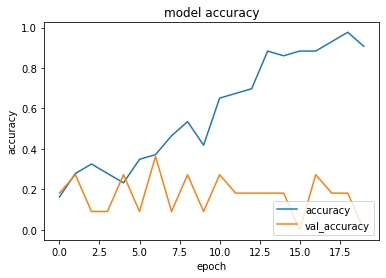

In [ ]:
# historyの中には学習の履歴があるので、確認する。
# 以下では、学習データとテストデータのaccuracyをプロットしている。

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [ ]:
# テストデータに適用
predict_classes = model.predict_classes(X_test)

# マージ。yのデータは元に戻す
mg_df = pd.DataFrame({'predict': predict_classes, 'class': np.argmax(y_test, axis=1)})

# confusion matrix
pd.crosstab(mg_df['class'], mg_df['predict'])

/Users/m.kazu/opt/anaconda3/envs/suumo_tensor_py39/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predict,0,2,3,4,5
class,,,,,
0,1,1,0,0,0
1,3,1,0,0,0
2,2,2,0,0,1
3,7,1,2,0,0
4,1,2,0,0,0
5,0,0,0,1,2
